In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

abtem.config.set({"local_diagnostics.progress_bar": True});

(tutorial:visualizations)=
# Visualizations

Visualizing the results is an integral part of understanding the output of a scattering simulation. The *ab*TEM visualization module wraps the `matplotlib` library to produce the typical visualizations needed when simulating electron microscopy, in this tutorial we cover how to customize the typical visualizations. We note that not every customization is possible within the framework of *ab*TEM; it may sometimes be more practical to create your own visualization from scratch.

```{seealso}
This tutorial only covers static visualizations. The *ab*TEM visulization module also features [animated](tutorial:animations) and [interactive]() visualizations, see the respective tutorials for more information.
```

## Customizing an image ensemble

The *ab*TEM visualization module is based on the concept of ensembles, see the appendix for details. Given an object with one or more ensemble axes *ab*TEM
 will create an "exploded" plot when you set `explode=True`. The exploded plot shows a 1D or 2D grid of images or line plots, where each image or line plot represents a member in the ensemble.

We create HRTEM images for silicon $\{100\}$ with a single ensemble dimension representing different values of defocus.

In [2]:
atoms_cell = ase.build.bulk("Si", cubic=True)

atoms = atoms_cell * (1, 1, 100)

potential = abtem.Potential(atoms, sampling=0.05)

wave = abtem.PlaneWave(energy=200e3)

defocus = np.linspace(0, 100, 3)

measurements = wave.multislice(potential).apply_ctf(defocus=defocus).compute()

[########################################] | 100% Completed |  3.4s


We create a visualization using the `.show` method and set `explode=True` to create an "exploded" grid plot. We set `common_color_scale=True` to show all the images on a single color scale, if this is set to `False` each image is scaled indepdently. We set `cbar=True` to included a colorbar and `cmap="gray"` to show the images using a grayscale colormap, see the `matplotlib` [documentation](https://matplotlib.org/stable/gallery/color/colormap_reference.html) for a full list of colormaps. 

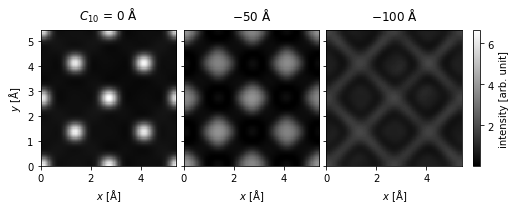

In [3]:
visualization = measurements.apply_ctf(semiangle_cutoff=30).show(
    explode=True,
    common_color_scale=True,
    figsize=(8, 8),
    cbar=True,
    cmap="gray",
)

The `.show` method produces a `MeasurementVisualization` object, the specific subtype will depend on the type of measurement object used to create the visualization. In this case, we obtain a `MeasurementVisualization2D` object. The `MeasurementVisualization` objects wraps a matplotlib figure.

In [4]:
object.__repr__(visualization.fig)

'<matplotlib.figure.Figure object at 0x7efff0f56a60>'

In [5]:
visualization.axes

We can convert the `AxesGrid` to a `numpy` array of matplotlib `Axes`. The `numpy` array is always 2D:

In [6]:
np.array(visualization.axes).shape

(3, 1)

We can adjust the vertical and horisontal spacing betwen images using the `.set_axes_padding` method, in our case we only need to adjust the horizontal spacing. The width of the colorbar can be adjusted using the `.set_cbar_size` method, finally we can adjust the left and right padding of the colorbar using the `.set_cbar_padding` method.

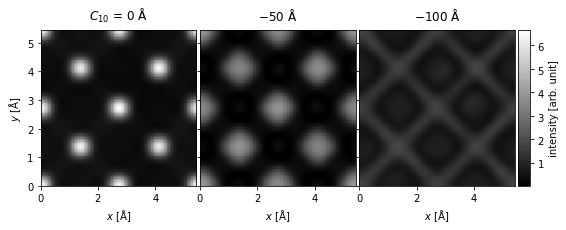

In [7]:
visualization.set_axes_padding((0.05, 0.0))
visualization.set_cbar_size(0.075)
visualization.set_cbar_padding((0.05, 0.0))

visualization.fig

We can change the units of the titles using the `.set_column_titles` method, the units of the `x` and `y`-axis can be changed by using the `set_x_units` or `set_y_units` method.

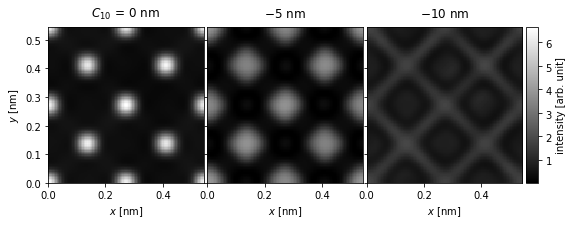

In [8]:
visualization.set_column_titles(units="nm")
visualization.set_x_units("nm")
visualization.set_y_units("nm")

visualization.fig

We can remove the titles by setting them to an empty string.

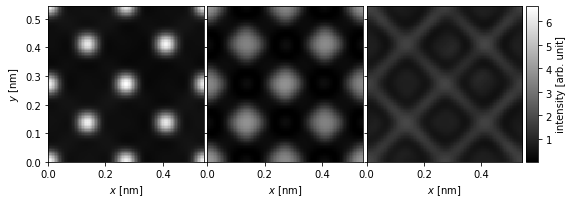

In [9]:
visualization.set_column_titles(titles="")

visualization.fig

The axes ticks and labels can be removed using the `axis_off` method. We can add a sizebar to preserve a description of the scale.

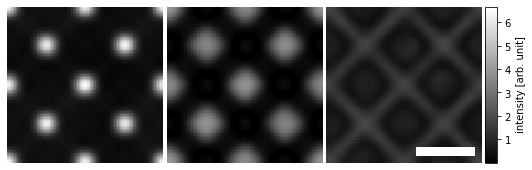

In [10]:
visualization.axis_off(spines=False)
visualization.set_sizebars(size=2, color="w")

visualization.fig

Finally, we can label each image using the metdata labels.

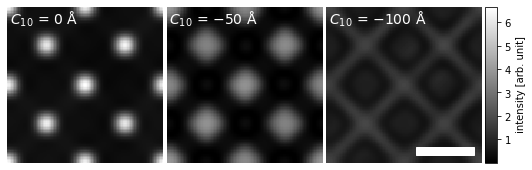

In [11]:
visualization.set_panel_labels(
    labels="metadata", frameon=False, prop={"fontsize": 14, "color": "w"}
)

visualization.fig

## 2D ensemble of images

In the next example, we demonstrate a 2D grid of graphene images for different values of defocus and spherical aberrations.

In [12]:
defocus = np.linspace(-50, 50, 7)
Cs = np.linspace(0, 400000, 5)
focal_spread = 30

atoms = ase.build.graphene(vacuum=2)

exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.05).multislice(atoms)

images = (
    exit_wave.apply_ctf(defocus=defocus, Cs=Cs, focal_spread=focal_spread)
    .intensity()
    .poisson_noise(5e5)
    .compute()
)

[########################################] | 100% Completed |  0.3s


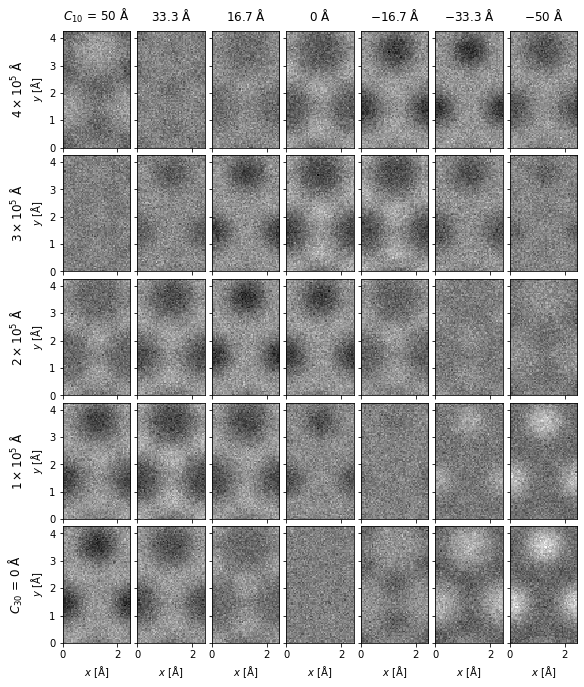

In [13]:
visualization = images.show(
    explode=True, figsize=(10, 10), common_color_scale=True, cmap="gray"
)

We remove the spacing between the images 

In [14]:
visualization.set_axes_padding([0.0, 0.0])
visualization.axis_off(spines=False)


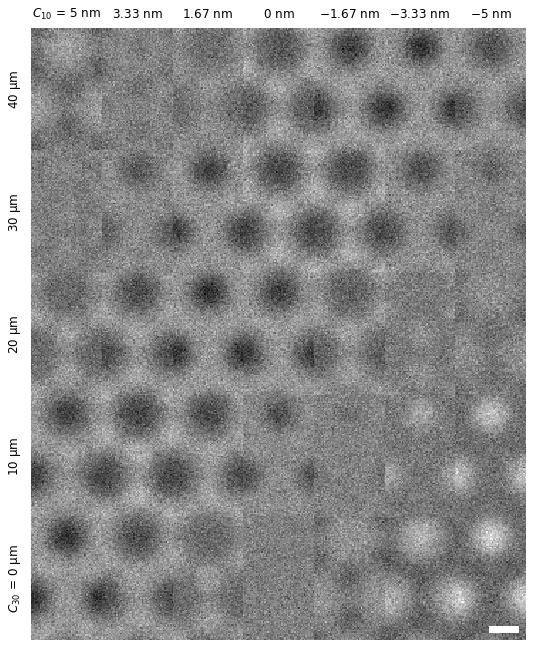

In [15]:
visualization.set_row_titles(units="um")
visualization.set_column_titles(units="nm")

visualization.set_sizebars(size=1, color="w")

visualization.fig

## Diffraction spots

In [16]:
atoms_cell = ase.build.bulk("Si", cubic=True)

atoms = atoms_cell * (1, 1, 10)

potential = abtem.Potential(atoms, sampling=0.05)

wave = abtem.PlaneWave(energy=200e3)

wave.grid.match(potential)

measurements = wave.multislice(potential).compute()

spots = measurements.diffraction_patterns().index_diffraction_spots(
    cell=atoms_cell.cell, threshold=1e-4
)

[########################################] | 100% Completed |  0.2s


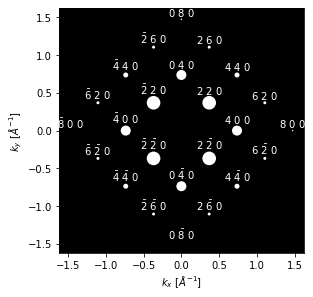

In [17]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["w"])

visualization = (
    spots.crop(60)
    .block_direct()
    .show(
        explode=False,
        scale=0.5,
        cmap=cmap,
        power=0.5,
        common_color_scale=True,
        display=False,
    )
)

for ax in np.array(visualization.axes).ravel():
    ax.set_facecolor("k")

visualization.set_x_units(units="1/Å")
visualization.set_y_units(units="1/Å")

visualization.set_miller_index_annotations(0.00015, size=10, color="w")

visualization.fig

## Domain coloring

The phase and amplitude can be display simultaneously using a technique called domain coloring

In [18]:
probe = abtem.Probe(
    semiangle_cutoff=30,
    defocus=60,
    astigmatism=np.linspace(0, 70, 3),
    astigmatism_angle=np.pi / 4,
    gpts=256,
    extent=20,
    energy=200e3,
)
probes = probe.build().complex_images().compute()

[########################################] | 100% Completed |  0.1s


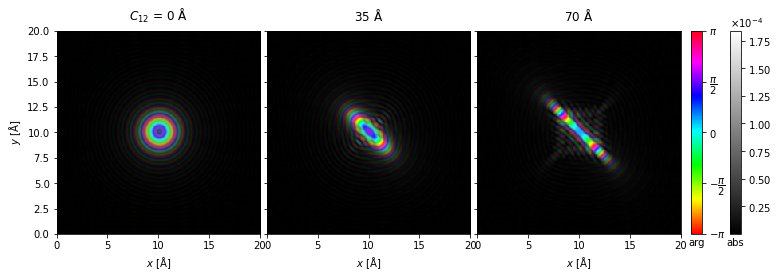

In [19]:
visualization = probes.show(
    explode=True, figsize=(12, 6), cbar=True, common_color_scale=True, cmap="hsv"
)

In [20]:
diffraction_patterns = (
    probe.build((0, 0)).diffraction_patterns(return_complex=True).crop(30)
)

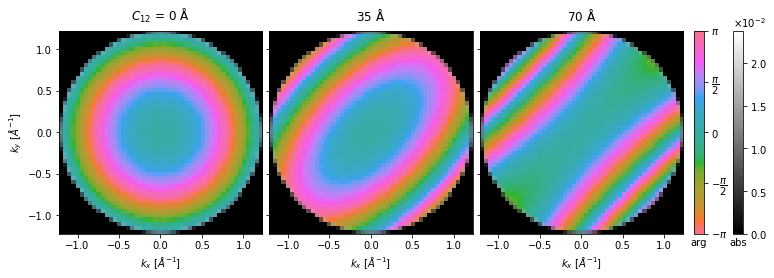

In [21]:
visualization = diffraction_patterns.show(
    explode=True, figsize=(12, 6), cbar=True, common_color_scale=True, cmap="hsluv"
)